# Roel's cascade 

The basic idea is that only the largest plumes are born binomially, and they then die into smaller and smaller plumes 




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()

import sys 
import pandas as pd

from binomial_function_collection import *

# Time stepping

In [2]:
def func_timestepping():
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Has discrete death (through demographics)
    """

    #--- time loop ----
    for t in range(ntim):


        #--- Energy cascade: decay of oldest objects in demographic record ---
        B_cas[:,:,:] = 0.
        if cascade_flag:
            for l in range(nsiz-1,0,-1):
                B_cas[:,:,l-1] = 2 * N[:,:,l,t-1,nage-1]   #split em in two, insert as birth of smaller objects
                print("t=%s  l:%s  max B_cas:%s" % (t, l, np.max(B_cas[:,:,l])) )

                
        #--- species loop ---
        for l in range(nsiz):

            
            #--- Object birthdays! Time-shift of the demographics levels ---
            for i in range(nage-1,0,-1):
                print("t=%s  l:%s  i:%s  max N:%s" % (t, l, i, np.max(N[:,:,l,t-1,i])) )
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten

            
            #--- Probability of birth p ---
            if pulse_growth_flag:
                
                dp_pulse[:,:] = 0.

                #--- Adjust p under certain rules ---
                
                # Rule 1: pulsating growth
                for i in range(len(x)):
                    for j in range(len(y)):
                        xr = np.array( range(i-nx_pulse,i+nx_pulse+1) )
                        xr = np.where(xr < 0  , xr+nx, xr)
                        xr = np.where(xr >= nx, xr-nx, xr)
                        yr = np.array( range(j-ny_pulse,j+ny_pulse+1) )
                        yr = np.where(yr < 0  , yr+ny, yr)
                        yr = np.where(yr >= ny, yr-ny, yr)
                        submesh = np.ix_( xr, yr )
                        #print( submesh)
                        dp_pulse[submesh] = dp_pulse[submesh] + f_pulse[:,:] * np.sum(N[i,j,l,t,:])
                    

                p[:,:,l,t] = p[:,:,l,t] + prob_sub * dp_pulse[:,:] * fac_pulse

                # Rule 2: environmental deformation, so that average birth rate is conserved at prob_sub
                if np.mean(p[:,:,l,t])>0.:
                    #print( np.mean(p[:,:,l,t]) )
                    fac_p = prob_sub / np.mean(p[:,:,l,t])
                    p[:,:,l,t] = p[:,:,l,t] * fac_p


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally
            
            
            #--- Update object number: add births as level 1 demographics ---
            #N[:,:,l,t,0] = B                
            N[:,:,l,t,0] = B + B_cas[:,:,l]  # add births due to E-cascade
            
            
            print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))

        
    return N, p, dp_pulse


# Settings  and initialization

In [3]:


#--- Grid parameters ----------
nx   = 5     #grid size
ny   = 5

#nsiz = 1       #nr of sizes in spectrum
nsiz = 5       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 4*60    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
#B_0[nsiz-1]    = 1.e-8   #average nr of object births / m2 / s
B_0[nsiz-1]    = 5.e-8   #average nr of object births / m2 / s

tau_D     = 300.*2.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata

#--- pulsating growth parameters
pulse_growth_flag = 0
#pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  40.    #factor of proportionality in impact of pulsating growth on p

#--- energy cascade
#cascade_flag = 0
cascade_flag = 1

#--- Advection parameters
u  = 5. #x wind, used for advection [m/s]
v  = 5. #y wind, used for advection [m/s]




#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)

B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #array containing object number



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
#--- set up pulsating growth stuff ---   
print(pulse_growth_flag)

if pulse_growth_flag:
    nx_pulse = np.int( r_pulse / dx)
    ny_pulse = np.int( r_pulse / dy)

    f_pulse  = np.empty( (2 * nx_pulse + 1, 2 * ny_pulse + 1) )  

    for i in range(f_pulse.shape[0]):
        for j in range(f_pulse.shape[0]):
            f_pulse[i,j] = np.max( [0., 1. - ( (dx * (i - nx_pulse))**2 + (dy * (j - ny_pulse))**2 )**0.5 / r_pulse ] )

prob_sub=1e-08
size=50.0 B0=0.0 N_tot_ref=0.0
size=150.0 B0=0.0 N_tot_ref=0.0
size=250.0 B0=0.0 N_tot_ref=0.0
size=350.0 B0=0.0 N_tot_ref=0.0
size=450.0 B0=5e-08 N_tot_ref=2999999.0
0


# Now the fun starts!

In [4]:
N, p, dp_pulse = func_timestepping()

t=0  l:4  max B_cas:0
t=0  l:3  max B_cas:0
t=0  l:2  max B_cas:0
t=0  l:1  max B_cas:0
t=0  l:0  i:9  max N:0
t=0  l:0  i:8  max N:0
t=0  l:0  i:7  max N:0
t=0  l:0  i:6  max N:0
t=0  l:0  i:5  max N:0
t=0  l:0  i:4  max N:0
t=0  l:0  i:3  max N:0
t=0  l:0  i:2  max N:0
t=0  l:0  i:1  max N:0
t=0  time = 0.0  sizebin 0 max birth:  0 0
t=0  l:1  i:9  max N:0
t=0  l:1  i:8  max N:0
t=0  l:1  i:7  max N:0
t=0  l:1  i:6  max N:0
t=0  l:1  i:5  max N:0
t=0  l:1  i:4  max N:0
t=0  l:1  i:3  max N:0
t=0  l:1  i:2  max N:0
t=0  l:1  i:1  max N:0
t=0  time = 0.0  sizebin 1 max birth:  0 0
t=0  l:2  i:9  max N:0
t=0  l:2  i:8  max N:0
t=0  l:2  i:7  max N:0
t=0  l:2  i:6  max N:0
t=0  l:2  i:5  max N:0
t=0  l:2  i:4  max N:0
t=0  l:2  i:3  max N:0
t=0  l:2  i:2  max N:0
t=0  l:2  i:1  max N:0
t=0  time = 0.0  sizebin 2 max birth:  0 0
t=0  l:3  i:9  max N:0
t=0  l:3  i:8  max N:0
t=0  l:3  i:7  max N:0
t=0  l:3  i:6  max N:0
t=0  l:3  i:5  max N:0
t=0  l:3  i:4  max N:0
t=0  l:3  i:3  max N:0
t

# plotting


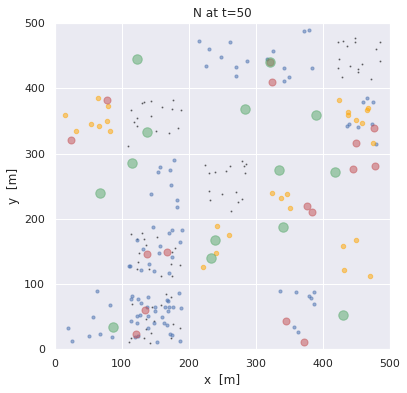

In [5]:
fig= plot_scatter_time(N,50,dx=dx,dy=dy)

In [6]:
#Working on making a nicer video with slower movement in the individual cells
plot_scatter_movie(N,0,100,name='cascadetest',dx=dx,dy=dy)


saved: mov/N_movie_cascadetest_dt000.png
saved: mov/N_movie_cascadetest_dt001.png
saved: mov/N_movie_cascadetest_dt002.png
saved: mov/N_movie_cascadetest_dt003.png
saved: mov/N_movie_cascadetest_dt004.png
saved: mov/N_movie_cascadetest_dt005.png
saved: mov/N_movie_cascadetest_dt006.png
saved: mov/N_movie_cascadetest_dt007.png
saved: mov/N_movie_cascadetest_dt008.png
saved: mov/N_movie_cascadetest_dt009.png
saved: mov/N_movie_cascadetest_dt010.png
saved: mov/N_movie_cascadetest_dt011.png
saved: mov/N_movie_cascadetest_dt012.png
saved: mov/N_movie_cascadetest_dt013.png
saved: mov/N_movie_cascadetest_dt014.png
saved: mov/N_movie_cascadetest_dt015.png
saved: mov/N_movie_cascadetest_dt016.png
saved: mov/N_movie_cascadetest_dt017.png
saved: mov/N_movie_cascadetest_dt018.png
saved: mov/N_movie_cascadetest_dt019.png
saved: mov/N_movie_cascadetest_dt020.png
saved: mov/N_movie_cascadetest_dt021.png
saved: mov/N_movie_cascadetest_dt022.png
saved: mov/N_movie_cascadetest_dt023.png
saved: mov/N_mov